# Import all libraries


In [1]:
import glob
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='once')

## Reading and preprocessing dataframe

In [2]:
def preprocessWeather(path_url):
    df = pd.read_csv(path_url)
    df.columns = df.columns.str.replace(' ', '')
    df[['FH', 'T', 'RH']] = df[['FH', 'T', 'RH']] / 10
    df['YYYYMMDD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')
    df['date'] = df['YYYYMMDD'] +  pd.to_timedelta(df['HH'], unit='h')
    df.drop(columns = ['#STN', 'DD', 'FF', 'FX', 'T10N', 'TD', 'Q', 
                       'P', 'VV', 'U', 'WW', 'IX', 'HH', 'YYYYMMDD'], inplace=True)
    df.set_index('date', inplace=True)
    return df

def preprocessResono(path_url):
    df = pd.read_csv(path_url)
    return df

In [3]:
df_Weather2020 = preprocessWeather("KNMI (Weather) 2020-2021/uurgeg_240_2011-2020.txt")
df_Weather2021 = preprocessWeather("KNMI (Weather) 2020-2021/uurgeg_240_2021-2030.txt")

df_Resono_Oct_Dec = preprocessResono("Resono.csv")

C:\Users\olivi\anaconda3\envs\my-r-env\lib\site-packages\ipykernel_launcher.py:1: DtypeWarning: Columns (15,16,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


#### Preprocessing of the weather data

In [4]:
df_weather = pd.concat([df_Weather2020, df_Weather2021], axis=0)
df_weather = df_weather.loc['2020-10': '2022-01-01 00:00']

cols_int = ['SQ', 'DR', 'N', 'M', 'R', 'S', 'O', 'Y']
cols_float = ['FH', 'T']

df_weather[cols_float] = df_weather[cols_float].apply(pd.to_numeric, errors='coerce', axis=1)
df_weather[cols_int] = df_weather[cols_int].apply(pd.to_numeric, errors='coerce', axis=1)
df_weather['RH'] = df_weather['RH'].apply(lambda x: 0.05 if x==-0.1 else x)


In [5]:
df_weather_resample = pd.concat([df_weather[['FH', 'T', 'N']].resample('15T').interpolate(method='linear'),
                    df_weather[['RH', 'DR', 'SQ', 'M', 'R', 'S', 'O', 'Y']].resample('15T').bfill()],
                   axis=1)

df_weather_resample[['DR', 'SQ']] = df_weather_resample[['DR', 'SQ']] * 1.5
df_weather_resample['RH'] = df_weather_resample['RH'] / 4

#### Merging the Resono and weather data and rename columns

In [6]:
df_Resono = df_Resono_Oct_Dec.drop(columns = ["Unnamed: 0"])
df_Resono['Start'] = pd.to_datetime(df_Resono['Start'])
df_Resono['Start'] = pd.to_datetime(df_Resono['Start'].dt.strftime("%Y-%m-%d %H:%M:%S"))

In [7]:
df_Resono_index = df_Resono.set_index('Start')
df_Resono_index = df_Resono_index.loc['2020-10':]

In [8]:
merge_resono_weather = pd.merge(df_Resono_index, df_weather_resample, left_index=True, right_index=True, how='left')
merge_resono_weather = merge_resono_weather.rename({'T': 'Temperature', 'N': 'Clouds', 'FH': 'Windspeed',
                                                    'RH': 'Rain amount', 'DR': 'Rain duration' , 'SQ': 'Sun duration',
                                                    'M': 'Fog', 'R': 'Rain', 'S': 'Snow', 'O': 'Thunder', 'Y': 'Ice'},
                                                   axis=1) 
merge_resono_weather

Location  Visits Start_Dates Start_Time  Windspeed  \
2020-10-01 00:00:00    Erasmuspark     731  2020-10-01   00:00:00        5.0   
2020-10-01 00:00:00     Oosterpark     107  2020-10-01   00:00:00        5.0   
2020-10-01 00:00:00  Rembrandtpark     523  2020-10-01   00:00:00        5.0   
2020-10-01 00:00:00   Sarphatipark      96  2020-10-01   00:00:00        5.0   
2020-10-01 00:00:00     Vondelpark      41  2020-10-01   00:00:00        5.0   
...                            ...     ...         ...        ...        ...   
2020-12-31 23:15:00     Vondelpark    1094  2020-12-31   23:15:00        2.0   
2020-12-31 23:30:00    Erasmuspark     443  2020-12-31   23:30:00        2.0   
2020-12-31 23:30:00     Oosterpark      92  2020-12-31   23:30:00        2.0   
2020-12-31 23:30:00   Sarphatipark     923  2020-12-31   23:30:00        2.0   
2020-12-31 23:30:00     Vondelpark    1079  2020-12-31   23:30:00        2.0   

                     Temperature  Clouds  Rain amount  Rain duration  \
2020-10-01 00:00:00       15.600     8.0          0.0            0.0   
2020-10-01 00:00:00       15.600     8.0          0.0            0.0   
2020-10-01 00:00:00       15.600     8.0          0.0            0.0   
2020-10-01 00:00:00       15.600     8.0          0.0            0.0   
2020-10-01 00:00:00       15.600     8.0          0.0            0.0   
...                          ...     ...          ...            ...   
2020-12-31 23:15:00       -0.625     1.0          0.0            0.0   
2020-12-31 23:30:00       -0.550     1.0          0.0            0.0   
2020-12-31 23:30:00       -0.550     1.0          0.0            0.0   
2020-12-31 23:30:00       -0.550     1.0          0.0            0.0   
2020-12-31 23:30:00       -0.550     1.0          0.0            0.0   

                     Sun duration  Fog  Rain  Snow  Thunder  Ice  
2020-10-01 00:00:00           0.0    0     0     0        0    0  
2020-10-01 00:00:00           0.0    0     0     0        0    0  
2020-10-01 00:00:00           0.0    0     0     0        0    0  
2020-10-01 00:00:00           0.0    0     0     0        0    0  
2020-10-01 00:00:00           0.0    0     0     0        0    0  
...                           ...  ...   ...   ...      ...  ...  
2020-12-31 23:15:00           0.0    0     0     0        0    0  
2020-12-31 23:30:00           0.0    0     0     0        0    0  
2020-12-31 23:30:00           0.0    0     0     0        0    0  
2020-12-31 23:30:00           0.0    0     0     0        0    0  
2020-12-31 23:30:00           0.0    0     0     0        0    0  

[43252 rows x 15 columns]

<AxesSubplot:xlabel='Rain amount', ylabel='Visits'>

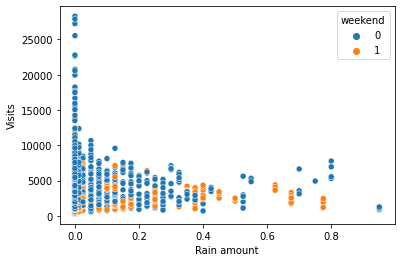

In [171]:
# oosterpark = merge_resono_weather[merge_resono_weather.Location == 'Vondelpark']
# oosterpark = oosterpark[oosterpark.Visits > 250]
# oosterpark.head()
# oosterpark = oosterpark.between_time('08:00', '17:00')
# oosterpark.corr()
sns.scatterplot(data=oosterpark, x="Rain amount", y="Visits", hue='weekend')

In [51]:
'''
Windspeed       = Mean wind speed during the time period (in m/s)
Temperature     = Temperature at 1.50 m at the time of observation
Clouds          = Cloud cover (in octants), at the time of observation (9=sky invisible)
Rain amount     = Quarterly precipitation amount
Rain duration   = Precipitation duration during the quarterly division (in minutes)
Sun duration    = Sunshine duration (in minutes)
Fog             = Fog  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Rain            = Rain  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Snow            = Snow  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Thunder         = Thunder  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
Ice             = Ice  0=no occurrence, 1=occurred during the preceding hour and/or at the time of observation
'''

In [151]:
oosterpark['weekend'] = oosterpark['index'].apply(lambda x: 1 if (x.weekday() == 5) or (x.weekday() == 6) else 0)
# ].apply(lambda x: 0.05 if x==-0.1 else x)

In [121]:
date = dt.datetime.today()

In [165]:
#oosterpark.set_index('index', inplace=True)
#oosterpark.drop('level_0', axis=1, inplace=True)